# Image segmentation with a Primal-Dual solver

$$
\min_{\mathbf{x} \in X} \frac{\sigma}{2} \mathbf{x}^T \mathbf{f} + J(\mathbf{x})  \quad s.t. \{ \mathbf{X}_{.,j}: \sum_{i=1}^{N_{cl}} X_{i,j} = r,\; X_{i,j} \geq 0 \quad \forall j\}
$$

where $\mathbf{x}$ is the flatten representation of a matrix $\mathbf{X}$ of size $N_{cl} \times N_{im}$ ($N_{cl}$ number of possible classes and $N_{im}$ number of points in image) and $\mathbf{f}$ is a weighting function that is also the flatten representation of a matrix $\mathbf{F}$ of size $N_{cl} \times N_{im}$. It its simplest form is, it can be created as follows: $f_{i,j} = |im_j - c_i|^2$, which means for each image point we compute the squared difference between its value and each class value. This term will favour image points to go in the class whose value is closest to the image value - without the second term, we could simply write a point-wise algorithm that fills each row of $\mathbf{X}$ with 0s and 1 at the location where the corresponding row of $\mathbf{F}$ is minimum. As a result we will get a segmented image which however is noisy and bad looking.


**The regularization term ($J(\mathbf{x})$):**

The term $J(\mathbf{x})$ aims at find a compromise between the previous result (which minimizes $\frac{\sigma}{2} \mathbf{x}^T$) and a segmented image with minimal total perimeter lenght. In general this term does however make it hard to solver the cost function, for this we will use a Primal-Dual solver. The result here will look nicer and smoother but we have no guarantee that each row of $\mathbf{X} has only one 1 and all 0s, rather we will get decimal numbers (which we could intepret as probabilities of being part of a class)

Different regularization terms could be used:

- Sum L1 norms of each gradient per each class: $J(\mathbf{x}) = \frac{\alpha}{2} \sum_{i=1}^{N_{cl}} ||\nabla \mathbf{X}_{i,.}||_1$
- Sum L21 norms : $J(\mathbf{x}) = \frac{\alpha}{2} \sum_{i=1}^{N_{cl}} ||\nabla \mathbf{X}_{i,.}||_{2,1}$
- L2 Norm of matrix: $\frac{\alpha}{2}||\nabla \mathbf{X}||_2$
- Intersection of convex set projections : $K_{i_1,i_2}= \{ X_{., j}: |X_{i_2, j} - X_{i_1, j}| \leq 1 \quad \forall i1<i2 \}  \quad \forall j$

The last option makes $\mathbf{X}$ more binary. We will explore all of them.

Most of the work here is following the paper *Antonin Chambolle, Daniel Cremers, Thomas Pock. A Convex Approach to Minimal Partitions. 2011.*

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import filtfilt
from scipy.linalg import solve
from scipy.sparse.linalg import lsqr
from sklearn.cluster import KMeans
from pylops.basicoperators import *
from pylops.signalprocessing import *
from pylops.utils.wavelets import *
from pylops.avo.poststack import *
from pylops.optimization.sparsity import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.segmentation import *

In [2]:
os.environ['NUMBA_NUM_THREADS']

'1'

## Image loading

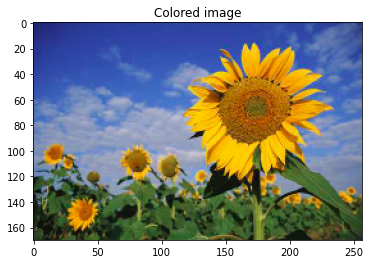

In [3]:
im = plt.imread('../testdata/sunflower.png')
#im = plt.imread('../testdata/butterfly.png')
im = im[::2, ::2, :3]
ny, nx, _ = im.shape

ig = im[..., 0]
#ig = np.mean(im, axis=-1)

plt.figure()
plt.imshow(im)
plt.title('Colored image');

## Primal-dual segmentation of grayscale image

Now we define 10 classes of colors

In [4]:
ncl = 10

cl = np.linspace(ig.min(), ig.max(), ncl+1)
dcl = cl[1] - cl[0]
cl = (cl + dcl/2)[:-1]
cl

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95])

Segment the image simply based on closeness of each pixel to the classes values (ie. $
\min_{\mathbf{x} \in X} \frac{\sigma}{2} \mathbf{x}^T \mathbf{f}  \quad s.t. \{ \mathbf{x}: \sum_i x_i = r,\; x_i \geq 0 \} $)

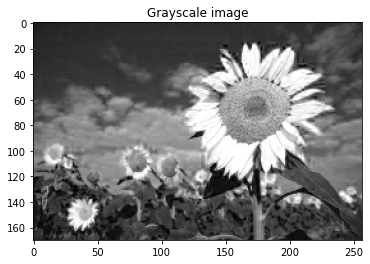

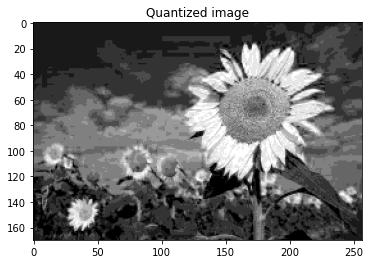

In [5]:
ic = np.floor(ig / dcl).astype(np.int)

plt.figure()
plt.imshow(ig, cmap='gray')
plt.title('Grayscale image');

plt.figure()
plt.imshow(ic, cmap='gray')
plt.title('Quantized image');

Now we include also the regularization term

In [6]:
# Data (difference between image and center of classes)
sigma = 10.
g = sigma / 2. * (ig.reshape(1, ny*nx) - cl[:, np.newaxis]) ** 2
g = g.ravel()

# Simplex
simp = Simplex(ny*nx*ncl, radius=1, dims=(ncl, ny*nx), axis=0, engine='numba', 
               maxiter=10, xtol=1e-3, ftol=1e-3, call=False)

sampling = 1.
L = 8. / sampling**2 # maxeig(Gop^H Gop)
tau = 1.
mu = 1. / (tau*L)

In [7]:
# Regularization: L1 norm of gradients
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')
Gop = BlockDiag([Gop]*ncl)
l1 = L1(sigma=0.5)

iseg = PrimalDual(simp, l1, Gop, tau=tau, mu=mu, z=g, theta=1., x0=np.zeros_like(g), 
                  niter=10, show=True)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   3.53696e-01   0.000e+00   9.976e+03   2.641e+03       1.262e+04
     2   4.01685e-01   0.000e+00   9.784e+03   1.845e+03       1.163e+04
     3   4.34109e-01   0.000e+00   8.866e+03   1.612e+03       1.048e+04
     4   4.60425e-01   0.000e+00   8.095e+03   1.582e+03       9.677e+03
     5   4.88418e-01   0.000e+00   7.538e+03   1.615e+03       9.153e+03
     6   4.90363e-01   0.000e+00   7.101e+03   1.676e+03       8.776e+03
     7   4.83408e-01   0.000e+00   6.754e+03   1.746e+03       8.500e+03
     8   4.755

In [8]:
# Regularization: sum of L21 norms of gradients for each class
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')
Gop = BlockDiag([Gop]*ncl)
l21 = VStack([L21(ndim=2, sigma=0.5)]*ncl, nn=[2*ny*nx]*ncl)

In [9]:
iseg1 = PrimalDual(simp, l21, Gop, tau=tau, mu=mu, z=g, theta=1., x0=np.zeros_like(g), 
                   niter=10, show=True)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   3.53696e-01   0.000e+00   8.193e+03   2.641e+03       1.083e+04
     2   4.01685e-01   0.000e+00   8.038e+03   1.845e+03       9.883e+03
     3   4.34109e-01   0.000e+00   7.259e+03   1.612e+03       8.872e+03
     4   4.60425e-01   0.000e+00   6.596e+03   1.582e+03       8.179e+03
     5   4.88418e-01   0.000e+00   6.118e+03   1.615e+03       7.733e+03
     6   4.90363e-01   0.000e+00   5.749e+03   1.676e+03       7.425e+03
     7   4.83408e-01   0.000e+00   5.461e+03   1.746e+03       7.207e+03
     8

In [10]:
# Djkstra set as regularization
iconv = Intersection(ncl, ny*nx*2, 1., 20, 1e-3, call=False)
iseg2 = PrimalDual(simp, iconv.H, Gop, tau=tau, mu=mu, z=g, theta=1., x0=np.zeros_like(g), 
                   niter=10, show=True)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.ProxOperator._AdjointOperator'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   3.53696e-01   0.000e+00   0.000e+00   2.641e+03       2.641e+03
     2   4.01685e-01   0.000e+00   0.000e+00   1.845e+03       1.845e+03
     3   4.34109e-01   0.000e+00   0.000e+00   1.612e+03       1.612e+03
     4   4.60425e-01   0.000e+00   0.000e+00   1.582e+03       1.582e+03
     5   4.88418e-01   0.000e+00   0.000e+00   1.615e+03       1.615e+03
     6   4.90363e-01   0.000e+00   0.000e+00   1.676e+03       1.676e+03
     7   4.83408e-01   0.000e+00   0.000e+00   1.746e+03       1.746e+03

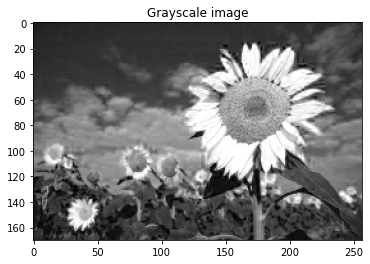

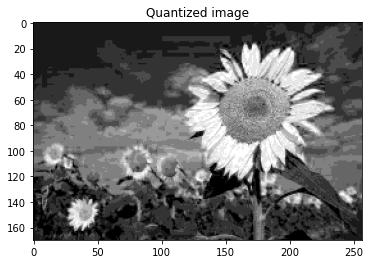

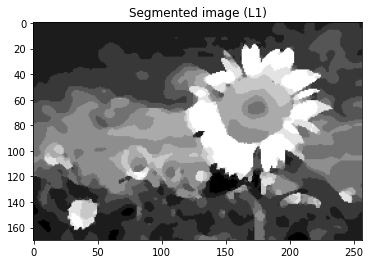

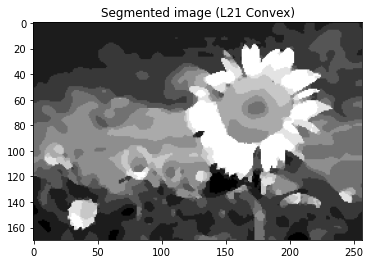

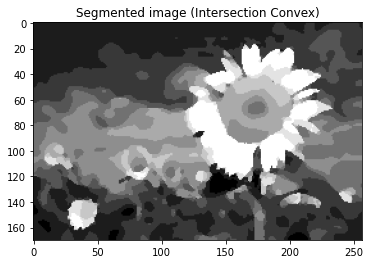

In [11]:
iseg_cl = iseg.reshape(ncl, ny*nx)
iseg_cl = np.argmax(iseg_cl, axis=0)
iseg_cl = iseg_cl.reshape(ny, nx)

iseg1_cl = iseg1.reshape(ncl, ny*nx)
iseg1_cl = np.argmax(iseg1_cl, axis=0)
iseg1_cl = iseg1_cl.reshape(ny, nx)

iseg2_cl = iseg2.reshape(ncl, ny*nx)
iseg2_cl = np.argmax(iseg2_cl, axis=0)
iseg2_cl = iseg2_cl.reshape(ny, nx)

plt.figure()
plt.imshow(ig, cmap='gray')
plt.title('Grayscale image')

plt.figure()
plt.imshow(ic, cmap='gray')
plt.title('Quantized image')

plt.figure()
plt.imshow(iseg_cl, cmap='gray')
plt.title('Segmented image (L1)')

plt.figure()
plt.imshow(iseg1_cl, cmap='gray')
plt.title('Segmented image (L21 Convex)')

plt.figure()
plt.imshow(iseg2_cl, cmap='gray')
plt.title('Segmented image (Intersection Convex)');

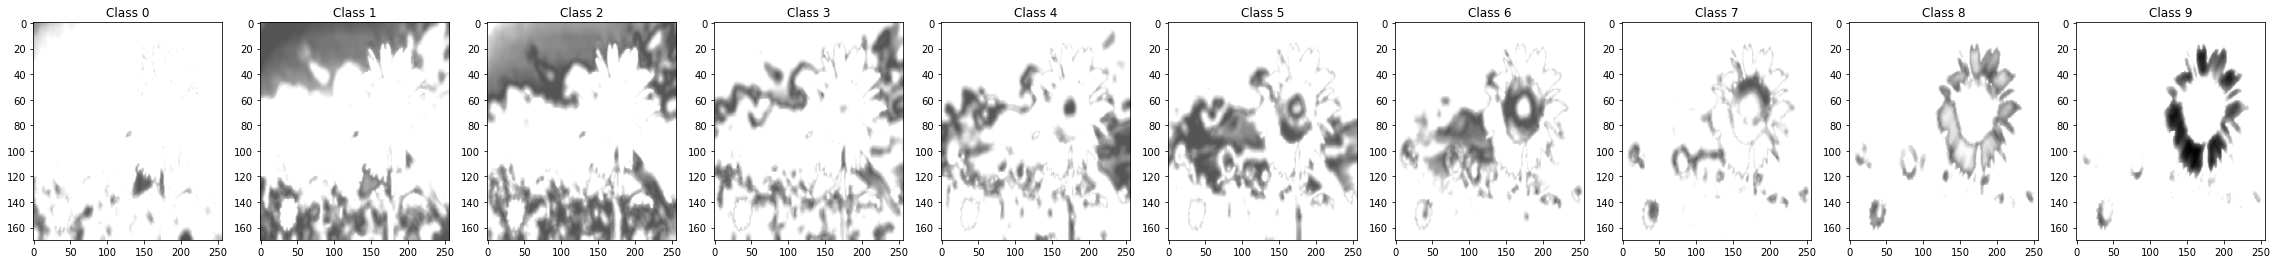

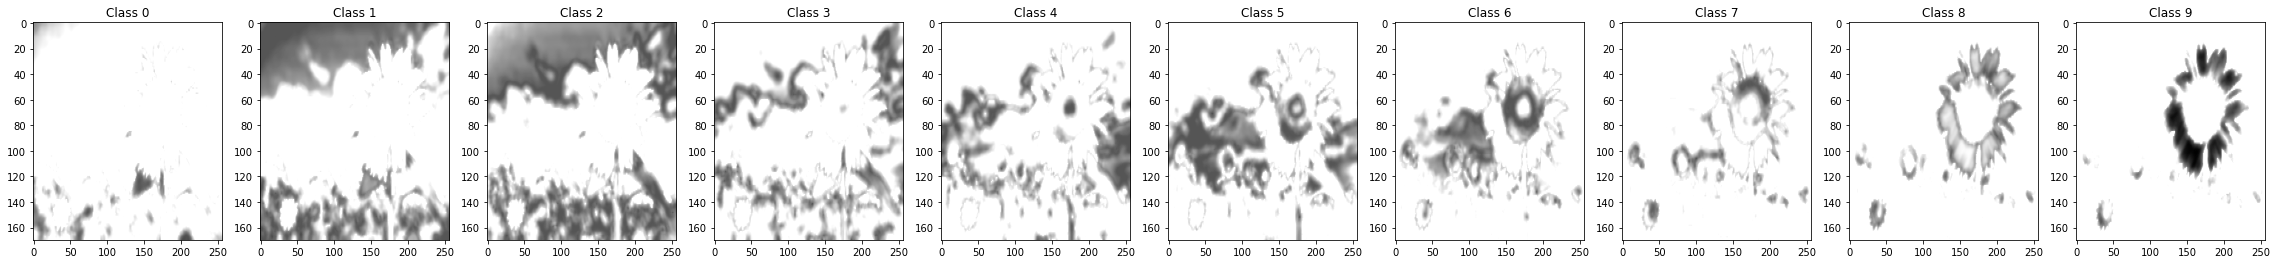

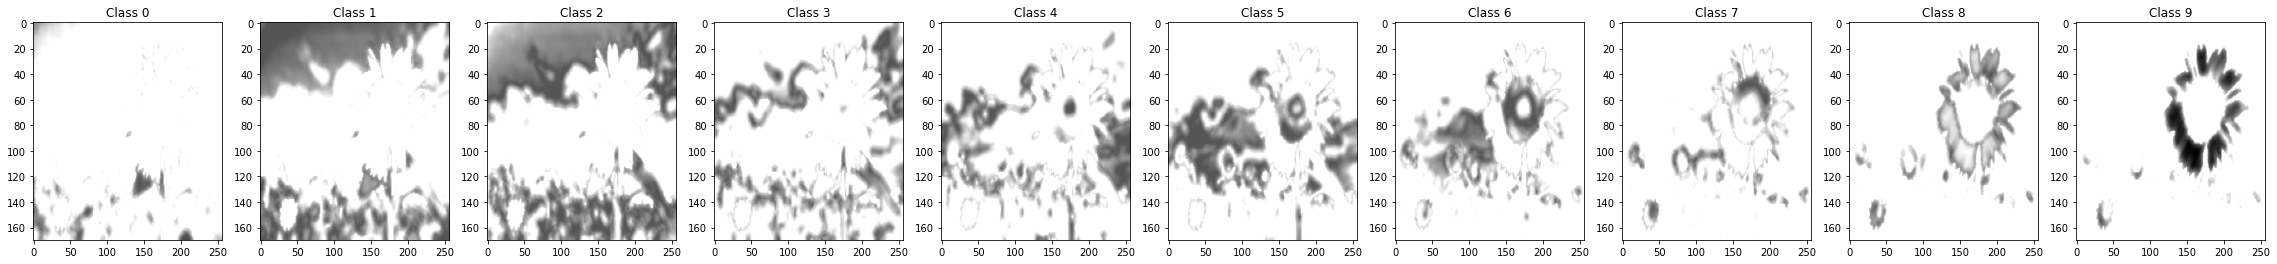

In [12]:
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    axs[icl].imshow(iseg.reshape(ncl, ny, nx)[icl], cmap='gray_r', vmin=0, vmax=1)
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
    
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    axs[icl].imshow(iseg1.reshape(ncl, ny, nx)[icl], cmap='gray_r', vmin=0, vmax=1)
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')
    
fig, axs = plt.subplots(1, ncl, figsize=(4*ncl, 4))
for icl in range(ncl):
    axs[icl].imshow(iseg2.reshape(ncl, ny, nx)[icl], cmap='gray_r', vmin=0, vmax=1)
    axs[icl].set_title('Class %d' % icl)
    axs[icl].axis('tight')

Use function

In [13]:
sigma = 10.
iseg2cl, iseg2 = Segment(ig, cl, sigma, 1., niter=10, 
                         callback=None, show=True, 
                         kwargs_simplex=dict(engine='numpy', maxiter=20, 
                                             xtol=1e-3, ftol=1e-3, call=False))
iseg2cl_numba, iseg2_numba = Segment(ig, cl, sigma, 1., niter=10, 
                                     callback=None, show=True, 
                                     kwargs_simplex=dict(engine='numba', maxiter=20, 
                                                         xtol=1e-3, ftol=1e-3, call=False))

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex'>
Proximal operator (g): <class 'pyproximal.proximal.VStack.VStack'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   3.52719e-01   0.000e+00   8.187e+03   2.641e+03       1.083e+04
     2   4.01685e-01   0.000e+00   8.036e+03   1.845e+03       9.881e+03
     3   4.33621e-01   0.000e+00   7.256e+03   1.612e+03       8.868e+03
     4   4.60853e-01   0.000e+00   6.592e+03   1.582e+03       8.174e+03
     5   4.88052e-01   0.000e+00   6.113e+03   1.615e+03       7.729e+03
     6   4.88864e-01   0.000e+00   5.746e+03   1.675e+03       7.421e+03
     7   4.83692e-01   0.000e+00   5.459e+03   1.746e+03       7.205e+03
     8   4.7

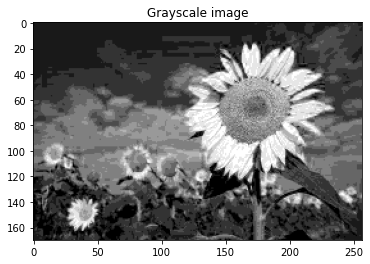

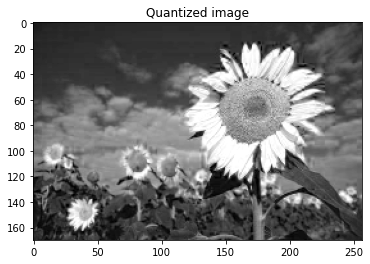

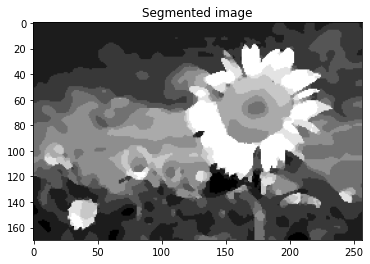

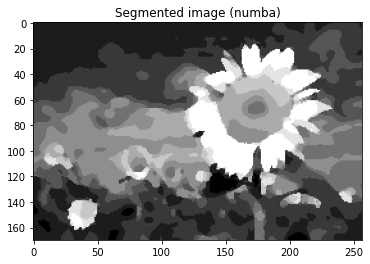

In [14]:
plt.figure()
plt.imshow(ic, cmap='gray')
plt.title('Grayscale image')

plt.figure()
plt.imshow(ig, cmap='gray')
plt.title('Quantized image')

plt.figure()
plt.imshow(iseg2, cmap='gray')
plt.title('Segmented image');

plt.figure()
plt.imshow(iseg2_numba, cmap='gray')
plt.title('Segmented image (numba)');

## Primal-dual segmentation of colored image

The main difference here is how we define $\mathbf{F}$:

$$
f_{i,j} = \sum_{ch}|im_{j, ch} - c_{i, ch}|^2
$$

Basically each image point is a vector that contains the 3 channels ($ch$) and the same applies for the class value. We compute the square of the difference of these vectors (not just scalars as in the grey scale case).

Note that other ways are also possible to define f, there is no right and wrong answer.

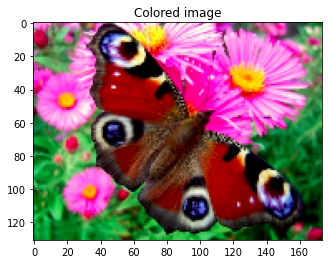

In [15]:
im = plt.imread('../testdata/butterfly.png')
im = im[::2, ::2, :3]
ny, nx, _ = im.shape

ig = im[..., 0]
#ig = np.mean(im, axis=-1)

plt.figure()
plt.imshow(im)
plt.title('Colored image');

First we perform K-mean clustering to define our classes and use the centroids to define the color of the class

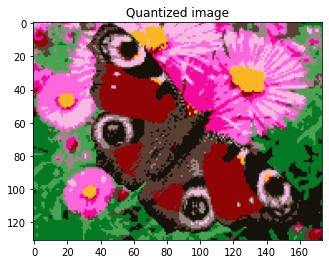

In [16]:
km = KMeans(n_clusters=ncl)
ic = km.fit_predict(im.reshape(ny*nx, 3))
cl = km.cluster_centers_

ic1 = np.zeros((ny*nx, 3))
for i in range(ny*nx):
    ic1[i] = cl[ic[i]]
ic1 = ic1.reshape(ny, nx, 3)

plt.figure()
plt.imshow(ic1)
plt.title('Quantized image');

In [17]:
# Data (difference between image and center of classes)
sigma = 10.
g = np.zeros((ncl, ny*nx))
for icl in range(ncl):
    g[icl] = sigma / 2. * np.linalg.norm(im.reshape(ny*nx, 3) - cl[icl], axis=1) ** 2
g = g.ravel()

# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')
Gop = BlockDiag([Gop]*ncl)

# Cost functions
simp = Simplex(ny*nx*ncl, radius=1, dims=(ncl, ny*nx), axis=0, engine='numba')
l1 = L1(sigma=0.5)

L = 8. / sampling**2 # maxeig(Gop^H Gop)
tau = 1.
mu = 1. / (tau*L)

In [18]:
iseg = PrimalDual(simp, l1, Gop, tau=tau, mu=mu, z=g,
                  theta=1., x0=np.zeros_like(g), niter=10, show=True)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 10

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   7.46396e-01   1.000e+00   9.721e+03   5.123e+03       1.484e+04
     2   8.97112e-01   1.000e+00   8.990e+03   3.947e+03       1.294e+04
     3   9.43306e-01   1.000e+00   7.773e+03   4.012e+03       1.179e+04
     4   9.03959e-01   1.000e+00   6.902e+03   4.359e+03       1.126e+04
     5   8.14428e-01   1.000e+00   6.348e+03   4.722e+03       1.107e+04
     6   7.11617e-01   1.000e+00   5.960e+03   5.021e+03       1.098e+04
     7   6.23895e-01   1.000e+00   5.654e+03   5.246e+03       1.090e+04
     8   5.682

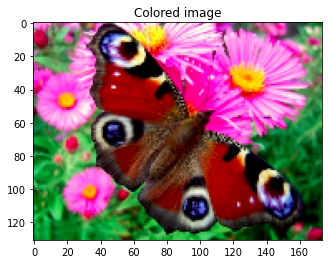

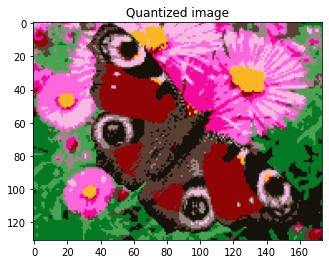

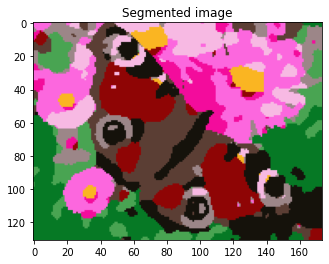

In [19]:
iseg1 = iseg.reshape(ncl, ny*nx)
iseg1 = np.argmax(iseg1, axis=0)
iseg1c = np.zeros((ny*nx, 3))
for i in range(ny*nx):
    iseg1c[i] = cl[iseg1[i]]
iseg1c = iseg1c.reshape(ny, nx, 3)

plt.figure()
plt.imshow(im, cmap='gray')
plt.title('Colored image')

plt.figure()
plt.imshow(ic1, cmap='gray')
plt.title('Quantized image')

plt.figure()
plt.imshow(iseg1c, cmap='gray')
plt.title('Segmented image');

## Primal-dual segmentation of triple point junction

In this example we want to impaint the grey area. Only 3 classes are defined: red(1,0,0), green(0,1,0) and blue(0,0,1). This example is particularly challanging as we have a junction in the middle where all 3 classes connect.

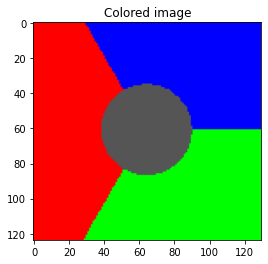

In [20]:
im = plt.imread('../testdata/triplepoint.png')
im = im[::5, ::5, :3]
ny, nx, _ = im.shape

im[im < 0.5] = 0 
im[im >= 0.5] = 1
im[np.sum(im, axis=2) == 0] = 1./3.

plt.figure()
plt.imshow(im)
plt.title('Colored image');

In [21]:
# Data (difference between image and center of classes)
sigma = 1.
ncl = 3
cl = np.eye(ncl)
g = np.zeros((ncl, ny*nx))
for icl in range(ncl):
    g[icl] = sigma / 2. * np.linalg.norm(im.reshape(ny*nx, ncl) - cl[icl], axis=1) ** 2
g = g.ravel()

# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')
Gop = BlockDiag([Gop]*ncl)

# Cost functions
simp = Simplex(ny*nx*ncl, radius=1, dims=(ncl, ny*nx), axis=0, engine='numba')
l1 = L1(sigma=.5)

L = 8. / sampling**2 # maxeig(Gop^H Gop)
tau = 1.
mu = 1. / (tau*L)

In [22]:
iseg = PrimalDual(simp, l1, Gop, tau=tau, mu=mu, z=g,
                  theta=1., x0=np.zeros(ny*nx*3),# im.reshape(ny*nx, 3).T.ravel(), 
                  niter=200, show=True)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 200

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.00000e+00   1.000e+00   2.997e+02   7.033e+02       1.004e+03
     2   1.00000e+00   1.000e+00   2.993e+02   7.033e+02       1.004e+03
     3   1.00000e+00   1.000e+00   2.978e+02   7.254e+02       1.024e+03
     4   1.00000e+00   1.000e+00   2.964e+02   7.412e+02       1.039e+03
     5   1.00000e+00   1.000e+00   2.953e+02   7.527e+02       1.049e+03
     6   1.00000e+00   1.000e+00   2.939e+02   7.568e+02       1.052e+03
     7   1.00000e+00   1.000e+00   2.927e+02   7.544e+02       1.048e+03
     8   1.00

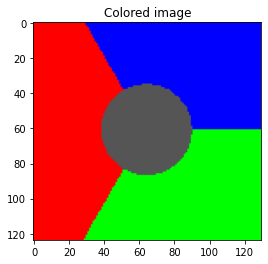

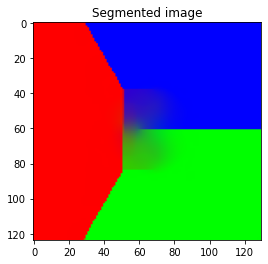

In [23]:
plt.figure()
plt.imshow(im, cmap='gray')
plt.title('Colored image')

plt.figure()
plt.imshow(iseg.reshape(3, ny, nx).transpose(1, 2, 0), cmap='gray')
plt.title('Segmented image');

In [24]:
Gop.shape

(96720, 48360)

In [25]:
# Regularization: sum of L21 norms of gradients for each class
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')
Gop = BlockDiag([Gop]*ncl)
l21 = VStack([L21(ndim=2, sigma=.5)]*ncl, nn=[2*ny*nx]*ncl)

In [26]:
iseg1 = PrimalDual(simp, l1, Gop, tau=tau, mu=mu, z=g,
                  theta=1., x0=im.reshape(ny*nx, 3).T.ravel(), niter=500, show=True)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 500

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.00000e+00   1.000e+00   2.995e+02   7.033e+02       1.004e+03
     2   1.00000e+00   1.000e+00   2.989e+02   7.033e+02       1.003e+03
     3   1.00000e+00   1.000e+00   2.975e+02   7.254e+02       1.024e+03
     4   1.00000e+00   1.000e+00   2.962e+02   7.412e+02       1.038e+03
     5   1.00000e+00   1.000e+00   2.951e+02   7.527e+02       1.049e+03
     6   1.00000e+00   1.000e+00   2.938e+02   7.568e+02       1.052e+03
     7   1.00000e+00   1.000e+00   2.924e+02   7.544e+02       1.048e+03
     8   1.00

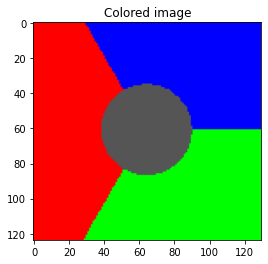

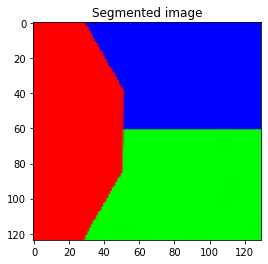

In [27]:
plt.figure()
plt.imshow(im, cmap='gray')
plt.title('Colored image')

plt.figure()
plt.imshow(iseg1.reshape(3, ny, nx).transpose(1, 2, 0), cmap='gray')
plt.title('Segmented image');

In [28]:
iconv = Intersection(ncl, ny*nx*2, 1., 20, 1e-7, call=False)

iseg1 = PrimalDual(simp, iconv.H, Gop, tau=tau, mu=mu, z=g,
                   theta=1., x0=im.reshape(ny*nx, 3).T.ravel(), niter=500, show=True)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.ProxOperator._AdjointOperator'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 500

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.00000e+00   1.000e+00   0.000e+00   7.033e+02       7.043e+02
     2   1.00000e+00   1.000e+00   0.000e+00   7.033e+02       7.043e+02
     3   1.00000e+00   1.000e+00   0.000e+00   7.254e+02       7.264e+02
     4   1.00000e+00   1.000e+00   0.000e+00   7.412e+02       7.422e+02
     5   1.00000e+00   1.000e+00   0.000e+00   7.527e+02       7.537e+02
     6   1.00000e+00   1.000e+00   0.000e+00   7.568e+02       7.578e+02
     7   1.00000e+00   1.000e+00   0.000e+00   7.544e+02       7.554e+0

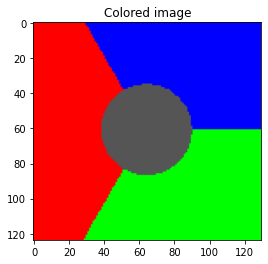

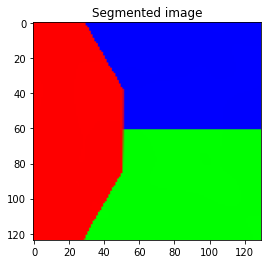

In [29]:
plt.figure()
plt.imshow(im, cmap='gray')
plt.title('Colored image')

plt.figure()
plt.imshow(iseg1.reshape(3, ny, nx).transpose(1, 2, 0), cmap='gray')
plt.title('Segmented image');

Same but now using a specially crafted g as suggested in the paper

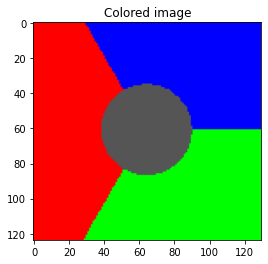

In [30]:
im = plt.imread('../testdata/triplepoint.png')
im = im[::5, ::5, :3]
ny, nx, _ = im.shape

im[im<0.5] = 0 
im[im>=0.5] = 1
im[np.sum(im, axis=2) == 0] = 1./3.

plt.figure()
plt.imshow(im)
plt.title('Colored image');

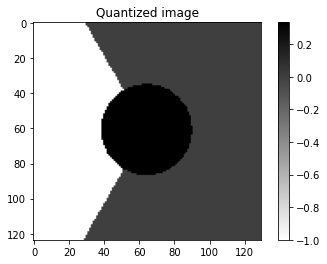

In [31]:
ncl = 3
g = np.zeros((ny*nx, ncl))
g[(im[...,0]==1).ravel(), 0] = -1.
g[(im[...,1]==1).ravel(), 1] = -1.
g[(im[...,2]==1).ravel(), 2] = -1.
g[(im[...,0]==1./3).ravel(), 0] = 1./3.
g[(im[...,0]==1./3).ravel(), 1] = 1./3.
g[(im[...,0]==1./3).ravel(), 2] = 1./3.

plt.figure()
plt.imshow(g[:, 0].reshape(ny, nx), cmap='gray_r')
plt.title('Quantized image')
plt.colorbar();

In [32]:
# Initial guess 
x0 = g / np.sum(g, axis=1)[:, np.newaxis]

# Data (difference between image and center of classes)
g = g.T.ravel()

# Gradient operator
sampling = 1.
Gop = Gradient(dims=(ny, nx), sampling=sampling, edge=False, 
               kind='forward', dtype='float64')
Gop = BlockDiag([Gop]*ncl)

# Cost functions
simp = Simplex(ny*nx*ncl, radius=1, dims=(ncl, ny*nx), axis=0, engine='numba')
l1 = L1(sigma=100.)

L = 8. / sampling**2 # maxeig(Gop^H Gop)
tau = 1.
mu = 1. / (tau*L)

In [33]:
iseg = PrimalDual(simp, l1, Gop, tau=tau, mu=mu, z=g,
                  theta=1., x0=x0.T.ravel(), niter=100, show=True)

Primal-dual: min_x f(Ax) + x^T z + g(x)
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.Simplex._Simplex_numba'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
Linear operator (A): <class 'pylops.basicoperators.BlockDiag.BlockDiag'>
Additional vector (z): vector
tau = 1.000000e+00	mu = 1.250000e-01
theta = 1.00		niter = 100

   Itn       x[0]          f           g          z^x       J = f + g + z^x
     1   1.00000e+00   1.000e+00   5.989e+04  -1.331e+04       4.659e+04
     2   1.00000e+00   1.000e+00   5.979e+04  -1.331e+04       4.648e+04
     3   1.00000e+00   1.000e+00   5.950e+04  -1.328e+04       4.622e+04
     4   1.00000e+00   1.000e+00   5.924e+04  -1.327e+04       4.598e+04
     5   1.00000e+00   1.000e+00   5.898e+04  -1.325e+04       4.573e+04
     6   1.00000e+00   1.000e+00   5.865e+04  -1.323e+04       4.542e+04
     7   1.00000e+00   1.000e+00   5.837e+04  -1.322e+04       4.515e+04
     8   1.00

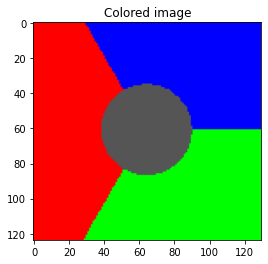

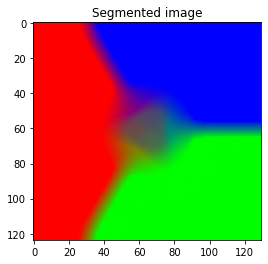

In [34]:
plt.figure()
plt.imshow(im, cmap='gray')
plt.title('Colored image')

plt.figure()
plt.imshow(iseg.reshape(ncl, ny, nx).transpose(1, 2, 0), cmap='gray')
plt.title('Segmented image');